# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**___Feng Kung_________

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2023-12-17 14:18:42.570777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 14:18:42.714815: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 14:18:42.719343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-17 14:18:42.719361: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

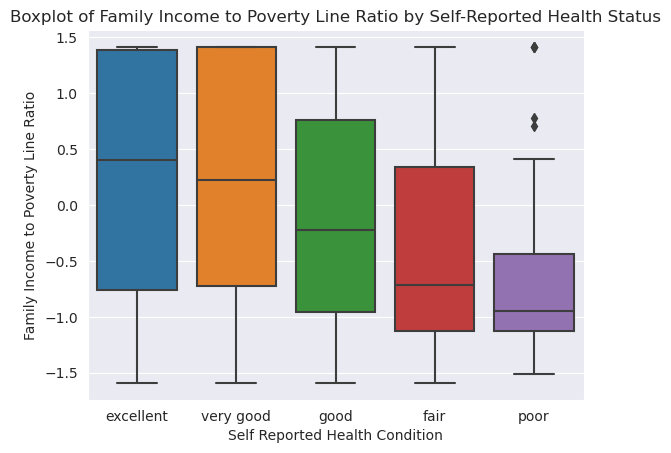

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

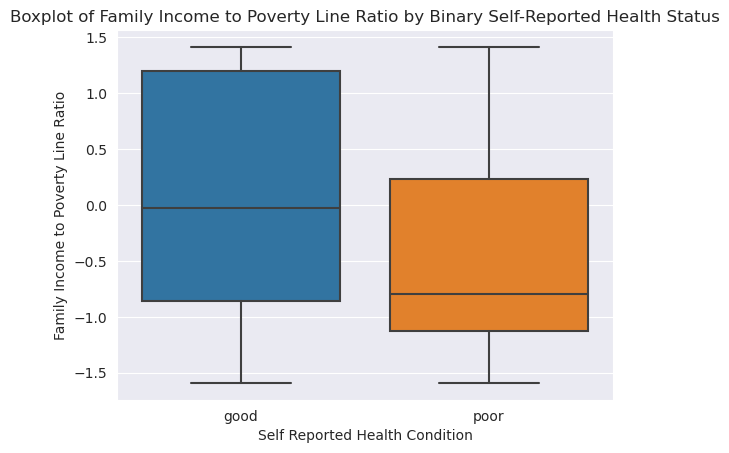

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

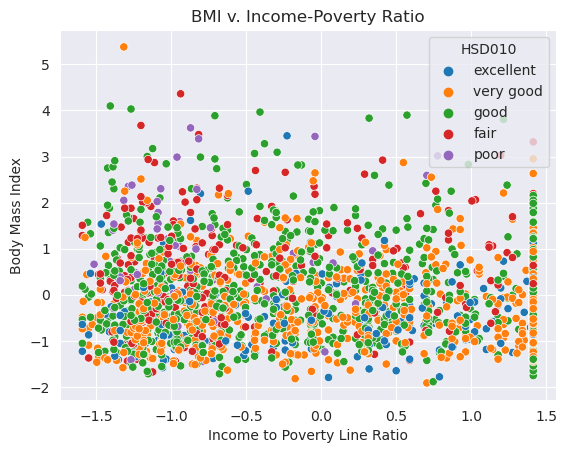

In [4]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [5]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

First I fit a PCA using all the components to make a skree plot showing the amount of variation explained by the number of principal components.

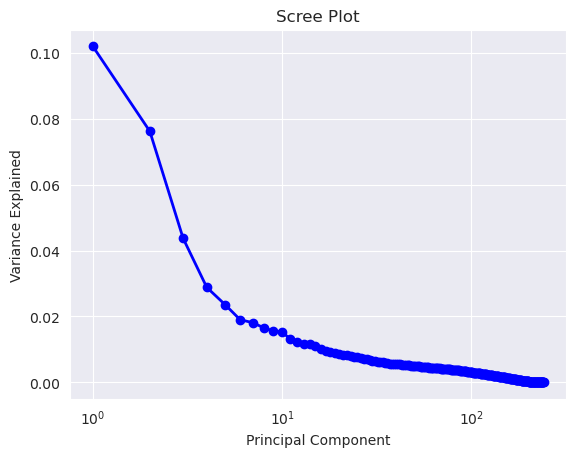

In [6]:
# fit PCA, keeping all, don't specify number of components for now
pca_all = PCA()
principalComponents = pca_all.fit_transform(nhanes_scaled)

# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

The amount of variation explained by added components starts to see diminishing returns after the 6th component.
The curve starts to flatten out. There does seem to be some gains through at least the 10th component. Lets plot the barpot for 10 components and get a better look.

### Barplot of Components

In [7]:
pca10 = PCA(n_components=10)
principalComponents10 = pca10.fit_transform(nhanes_scaled)

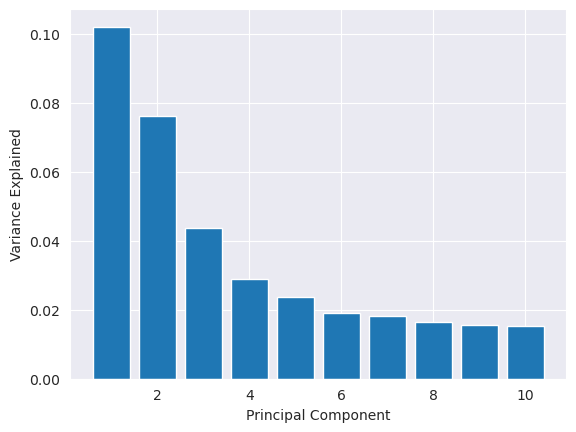

In [8]:
pca10_values = np.arange(pca10.n_components_) + 1

plt.bar(pca10_values, pca10.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### How many components will you use to fit a supervised learning model?

Looking at the barplot now instead of the skree plot still confirms that the amount of variation sees diminshing returns after the 6th component.

In [9]:
pca6 = PCA(n_components=6)
principalComponents6 = pca6.fit_transform(nhanes_scaled)
sum(pca6.explained_variance_ratio_)

0.29337043206555097

This is really a judgement call here. It will be easier to interpret less components, however the task we are given is prediction. We want to predict individuals' self-reported health conditions and it doesn't feel as important to be able to interpret the factors going into it and we do want accuracy for prediction. But we also don't want too much complexity. Less components can also reduce overfitting which can improve the performance of our model.

The explained variance ratio however is low, and often the target threshold is 70 - 80% explained variance, however there is not clear rule, and the skree plot definitely shows the drop off in return as more components are added.

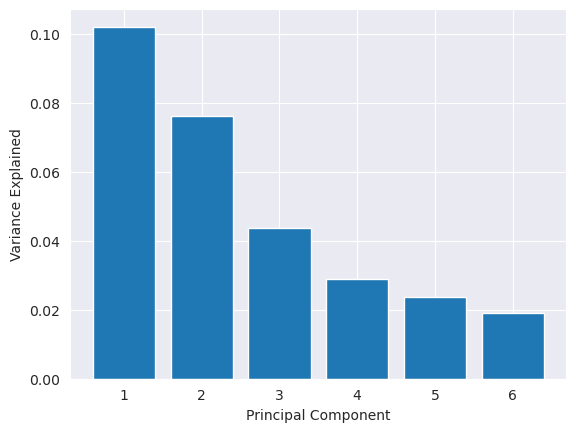

In [10]:
pca6_values = np.arange(pca6.n_components_) + 1

plt.bar(pca6_values, pca6.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### 2D Scatterplot of the first two components

In [11]:
# convert 6 components into a dataframe
pca_df = pd.DataFrame(data = principalComponents6, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                'principal component 3',
                                'principal component 4',
                                'principal component 5',
                                'principal component 6'])

# view factor loadings as dataframe
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,9.527811,-0.816225,-1.867072,-2.109566,-3.931921,-0.173352
1,-5.838338,-3.692573,3.805783,-1.028947,0.387364,1.622540
2,-0.719454,-2.573201,0.907894,-4.756012,-1.798307,0.864130
3,3.533627,-2.576982,-3.249051,-0.404050,3.989272,1.476034
4,-6.872094,-4.194241,0.886811,-0.849233,-0.527131,0.084268


<Figure size 640x480 with 0 Axes>

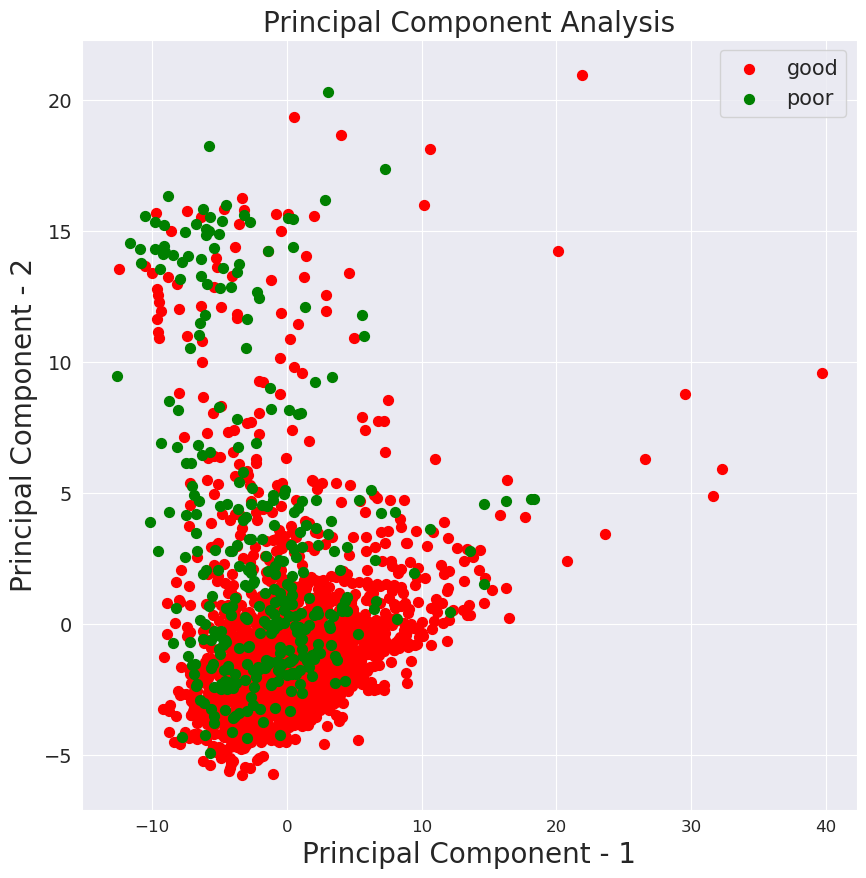

In [13]:
# plot
# ----------

nhanes_scaled['HSD010_binary'] = hsd010_binary  
nhanes_scaled.reset_index(inplace=True)

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'g']

# loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    indicesToKeep = nhanes_scaled['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c=color, s=50, label = target)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

Just having these two components doesn't seem to give you much ability to predict good or poor health, both of those are spread out and overlapping over different values of PC1 and PC1. Poor health does seem a slightly more with a lower PC1 and lower PC2 value. Will see if a model with more components explaining more variation will help.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

Choosing a Kmeans clustering algorithm. 

Kmeans is more computationally efficient for a large dataset like we have here than other clustering algorithms like dbscan or agglomerative.

Kmeans works by assigning points to k clusters, where k is chosen in advance and then tries to minimize the within cluster variation - the average squared distance of all data points within a cluster to its centroid.

### Cluster nhanes

In [12]:
# set random seed
np.random.seed(10)

In [13]:
# Import and prepare data
# Load csv
nhanes = pd.read_csv('nhanes.csv')

#scale
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)

#set index to the ID seqn
nhanes_scaled = nhanes_scaled.set_index('SEQN')

Elbow method for picking k

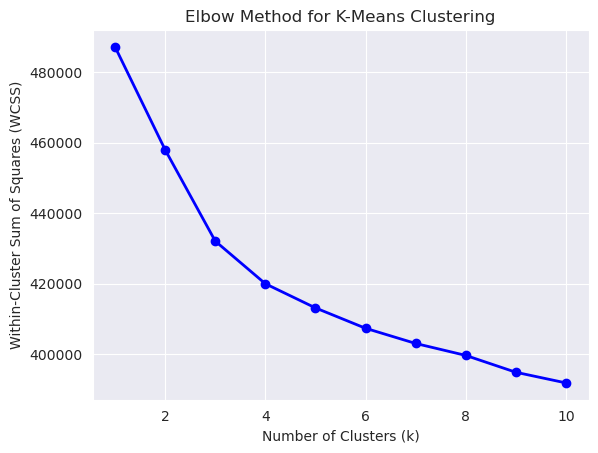

In [14]:
X = nhanes_scaled
# Define a range of k values to explore (e.g., 1 to 10)
k_range = range(1, 11)

# Calculate WCSS for each k value
wcss = []
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_range, wcss, 'o-', linewidth=2, color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for K-Means Clustering')
plt.grid(True)

# Look for the "elbow" point where the curve starts to flatten
plt.show()

It looks like diminishing returns after 4 clusters as the curve starts to flatten out, although not the flatest.

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

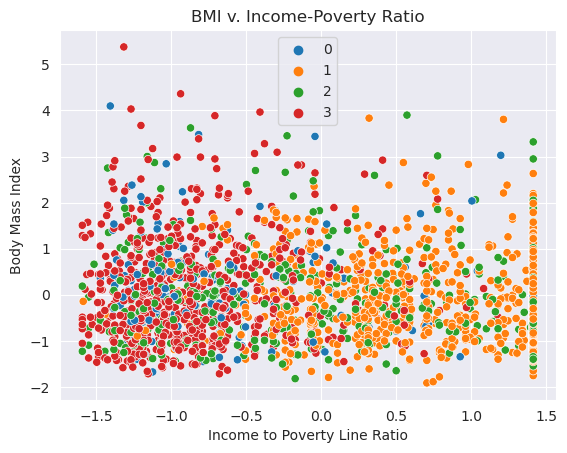

In [15]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                )

labels = kmeans.fit_predict(X) 

#plot on the BMI v Income to Poverty ratio

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = labels, palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Cluster 1 and cluster 3 do seem to map to low vs high income to poverty ratio, other clusters don't seem to map to either of these two features, are all pretty spread out and overlapping.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [16]:
# recalling the pca with 6 components
pca6 = PCA(n_components=6)
principalComponents6 = pca6.fit_transform(nhanes_scaled)

# making it a dataframe
column_names = [f"PC{i+1}" for i in range(6)]
pca_df = pd.DataFrame(principalComponents6, columns=column_names)

# using kmeans with 4 clusters
kmeans = KMeans(n_clusters=4,
                n_init=10,
               max_iter=300 #default
                )
# storing the labels resulting from the PCA
pcalabels = kmeans.fit_predict(principalComponents6)

In [17]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,9.611414,-0.843321,-1.917137,-2.221845,-3.930311,-0.156241
1,-5.714018,-3.904880,3.729200,-1.332446,0.381999,1.700322
2,-0.653053,-2.653291,0.859817,-4.798147,-1.804086,0.824117
3,3.591203,-2.588854,-3.249284,-0.392340,3.990981,1.370125
4,-6.840257,-4.241557,0.905866,-0.778809,-0.522014,0.051341


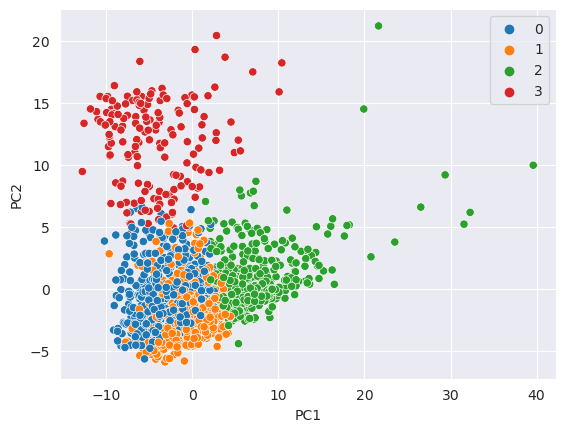

In [18]:
sns.scatterplot(x="PC1", y="PC2", data=pca_df, hue=pcalabels, palette="tab10")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Clustering of PCA Components of Nhanes Data")
plt.show()

The clusters are much better defined when we use the PCA components rather than the BMI and family income ratio, showing the value of using the PCA vs the original proxy features in the dataset.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [35]:
nhanes_scaled.head()

,HSD010,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010_binary
SEQN,,,,,,,,,,,,,,,,,,,,,
-1.755258,-1.720426,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,-1.720426
-1.752502,-1.720426,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,-1.720426
-1.751469,-0.666416,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,-0.666416
-1.750780,-0.666416,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,-0.666416
-1.749746,0.387594,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,0.387594


In [36]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [38]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 

nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,HSD010_binary
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1,good
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1,good
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2,good
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2,good
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3,good


In [40]:
nhanes_scaled_binary = pd.get_dummies(nhanes_scaled['HSD010_binary'])
nhanes_scaled_binary.head()

,good,poor
SEQN,,
73568,1,0
73576,1,0
73579,1,0
73581,1,0
73584,1,0


In [41]:
# partition data
# -----------

y = nhanes_scaled_binary

X = nhanes_scaled.drop(['HSD010_binary'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [42]:
y_train

,good,poor
SEQN,,
76577,1,0
82924,1,0
80855,0,1
78051,1,0
76032,1,0
...,...,...
83455,1,0
79434,1,0
80196,1,0


In [44]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(..., ...)
#y_test = keras.utils.to_categorical(..., ...)

num_classes = y_test.shape[1]

In [46]:
# create neural network model
# -----------
model = Sequential()

#Dense(...) creates a regular densely connected layer. 
#relu is a rectifier activation function.

model.add(Dense(num_classes, input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

#A softmax activation function is used on the output layer to turn the outputs into 
#probability-like values. 

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

#categorical_crossentropy is a logarithmic loss function and
#adam is a gradient descent algorithm

model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 0.6768 - accuracy: 0.8359 - val_loss: 0.6673 - val_accuracy: 0.8488 - 712ms/epoch - 89ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6599 - accuracy: 0.8359 - val_loss: 0.6488 - val_accuracy: 0.8488 - 39ms/epoch - 5ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6389 - accuracy: 0.8359 - val_loss: 0.6264 - val_accuracy: 0.8488 - 39ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6149 - accuracy: 0.8359 - val_loss: 0.6005 - val_accuracy: 0.8488 - 39ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 0.5866 - accuracy: 0.8359 - val_loss: 0.5722 - val_accuracy: 0.8488 - 38ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 0.5571 - accuracy: 0.8359 - val_loss: 0.5426 - val_accuracy: 0.8488 - 39ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 0.5270 - accuracy: 0.8359 - val_loss: 0.5138 - val_accuracy: 0.8488 - 40ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 0.4987 - accuracy: 0.8359 - val_loss: 0.4873 - val_accuracy: 0.8488 - 39ms/epoch - 5ms/step
Epoch 9/10
8/8 - 0s - loss: 0.4735 - a

### Neural Network on Principal Components

In [49]:
# partition data
# -----------
y = nhanes_scaled_binary
X = principalComponents6

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [50]:
num_classes = y_train.shape[1]

In [51]:
# create neural network model
# -----------
model = Sequential()

#Dense(...) creates a regular densely connected layer. 
#relu is a rectifier activation function.

model.add(Dense(num_classes, input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

#A softmax activation function is used on the output layer to turn the outputs into 
#probability-like values. 

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

#categorical_crossentropy is a logarithmic loss function and
#adam is a gradient descent algorithm

model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 0.6930 - accuracy: 0.5827 - val_loss: 0.6886 - val_accuracy: 0.8372 - 588ms/epoch - 73ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6859 - accuracy: 0.8333 - val_loss: 0.6817 - val_accuracy: 0.8488 - 37ms/epoch - 5ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6793 - accuracy: 0.8359 - val_loss: 0.6749 - val_accuracy: 0.8488 - 37ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6727 - accuracy: 0.8359 - val_loss: 0.6678 - val_accuracy: 0.8488 - 41ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6656 - accuracy: 0.8359 - val_loss: 0.6601 - val_accuracy: 0.8488 - 38ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6576 - accuracy: 0.8359 - val_loss: 0.6515 - val_accuracy: 0.8488 - 36ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6484 - accuracy: 0.8359 - val_loss: 0.6418 - val_accuracy: 0.8488 - 34ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6380 - accuracy: 0.8359 - val_loss: 0.6309 - val_accuracy: 0.8488 - 38ms/epoch - 5ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6265 - a

### Neural Network on Principal Components + Cluster Membership

In [52]:
## partition data
# -----------
y = nhanes_scaled_binary 
X = principalComponents

cluster_labels = kmeans.labels_

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10,
                                                    stratify=cluster_labels)

num_classes = y_train.shape[1]

In [53]:
# create neural network model
# -----------
model = Sequential()

#Dense(...) creates a regular densely connected layer. 
#relu is a rectifier activation function.

model.add(Dense(num_classes, input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

#A softmax activation function is used on the output layer to turn the outputs into 
#probability-like values. 

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

#categorical_crossentropy is a logarithmic loss function and
#adam is a gradient descent algorithm

model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 0.6831 - accuracy: 0.7532 - val_loss: 0.6783 - val_accuracy: 0.8450 - 587ms/epoch - 73ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6737 - accuracy: 0.8372 - val_loss: 0.6695 - val_accuracy: 0.8450 - 42ms/epoch - 5ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6641 - accuracy: 0.8372 - val_loss: 0.6604 - val_accuracy: 0.8450 - 41ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6540 - accuracy: 0.8372 - val_loss: 0.6506 - val_accuracy: 0.8450 - 37ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6431 - accuracy: 0.8372 - val_loss: 0.6400 - val_accuracy: 0.8450 - 37ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6308 - accuracy: 0.8372 - val_loss: 0.6287 - val_accuracy: 0.8450 - 37ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6178 - accuracy: 0.8372 - val_loss: 0.6165 - val_accuracy: 0.8450 - 37ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6037 - accuracy: 0.8372 - val_loss: 0.6035 - val_accuracy: 0.8450 - 36ms/epoch - 5ms/step
Epoch 9/10
8/8 - 0s - loss: 0.5886 - a

Model 1 - original features
Model 2 - PCA
Model 3 - PCA and clustering

Accuracy:

All models have similar accuracy for both training and validation and should do well on prediction.
Model 3 (PCA + clustering) has slightly higher training accuracy (0.8372) compared to model 1 and 2 (0.8359). However, model 3's validation accuracy (0.8450) is slightly lower than model 1 and model 2 (0.8488).

Loss:

Model 1 (original features) has the lowest training and validation loss (0.4520 and 0.4452, respectively), 
Models 2 and 3 have higher losses, possibly overfitting or less optimal fit to the data.

Training Time:

Models 2 and 3 have slightly faster training times compared to model 1 which is advantageous because there would be less computational cost.


## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is about reducing the dimensionality of the data and does it by projecting data onto a new set of axes, the principal components. Clustering also reduces dimensionality but it does it by clustering similar data points, not creating new features. PCA is unsupervised and often used for pre-processing data. Clustering is used on its own to analyze data.

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

In this analysis, I did not see any gains from this combination. However, some issues may have been first that reducing the data to 6 principal components may not have been a good choice. I chose it to reduce complexity, however the explained variance ratio was only about 30%. Thus some of the relevant information in the data to make better predictions might have been lost when reduced.

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Dimensionality reduction is a big use of unsupervised techniques. Large datasets have so many features it can be very computationally expensive in danger of overfitting if fed directly into the supervised learning. Unsupervised techniques like PCA can transform the information, projecting onto the principal components and producing fewer dimensions, but identifying whats critical. This reduces computational time and overfitting, and improves performance. By reducing it to principal components, it also helps with collinearity which is a common issue in social sciences research.